In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
train= pd.read_csv('/content/Price_Train.csv')
test= pd.read_csv('/content/Price_Test.csv')

In [3]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
train_open= train.iloc[:, 1:2].values

In [5]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [6]:
train_open_scaled[60]

array([0.08627874])

In [7]:
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [8]:
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [9]:
xtrain.shape

(1198, 60, 1)

In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [11]:
regression= Sequential()

regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
regression.add(Dense(units=1))

regression.compile(optimizer='adam',loss='mean_squared_error')
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 9s 88ms/step - loss: 0.0501
Epoch 2/100
40/40 [==============================] - 4s 101ms/step - loss: 0.0055
Epoch 3/100
40/40 [==============================] - 4s 88ms/step - loss: 0.0053
Epoch 4/100
40/40 [==============================] - 3s 87ms/step - loss: 0.0049
Epoch 5/100
40/40 [==============================] - 4s 101ms/step - loss: 0.0049
Epoch 6/100
40/40 [==============================] - 4s 88ms/step - loss: 0.0052
Epoch 7/100
40/40 [==============================] - 4s 90ms/step - loss: 0.0053
Epoch 8/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0045
Epoch 9/100
40/40 [==============================] - 4s 88ms/step - loss: 0.0047
Epoch 10/100
40/40 [==============================] - 4s 88ms/step - loss: 0.0042
Epoch 11/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0048
Epoch 12/100
40/40 [==============================] - 4s 89ms/step - loss: 0.0038
Epoch 13/100
40/40 [=

In [12]:
test_open= test.iloc[:, 1:2].values
total= pd.concat([train['Open'],test['Open']],axis=0)
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1)
test_input= ss.transform(test_input)

In [13]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0])

In [14]:
xtest= np.array(xtest)

In [15]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

1/1 [==============================] - 1s 1s/step


In [16]:
predicted_value= ss.inverse_transform(predicted_value)

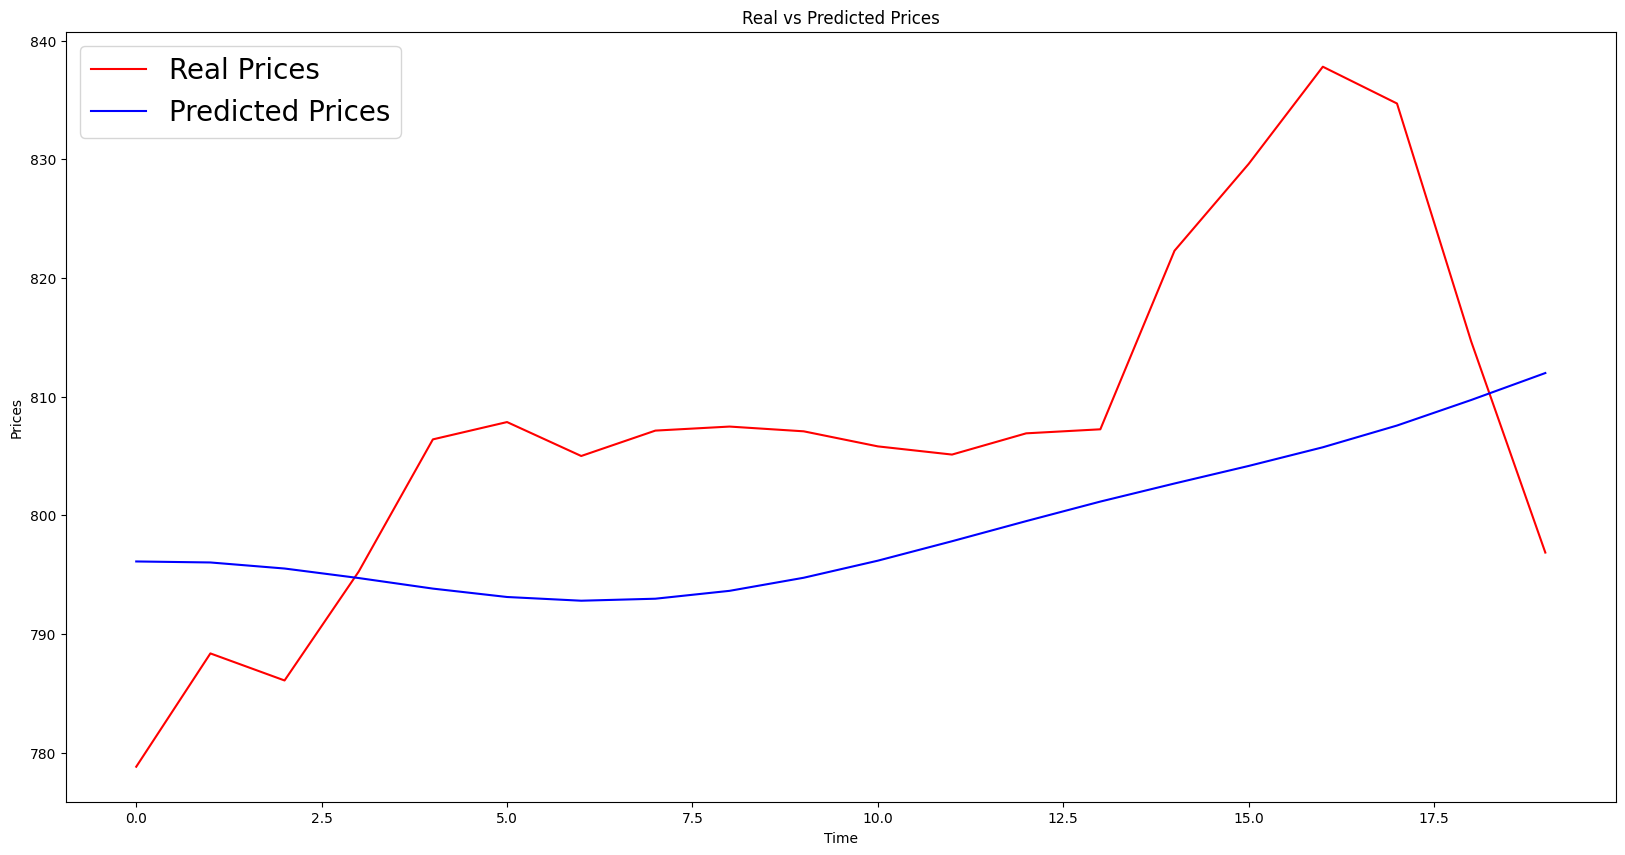

In [24]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)


In [18]:
from keras.wrappers.scikit_learn import KerasRegressor

In [19]:
def reg(optimizer):
    regression= Sequential()
    regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
    regression.add(Dropout(0.2))

    regression.add(LSTM(units=50,kernel_initializer= 'glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
    regression.add(Dropout(0.2))
    regression.add(Dense(units=1))

    regression.compile(optimizer=optimizer,loss='mean_squared_error')
    return regression
model= KerasRegressor(build_fn=reg)

<ipython-input-19-312a5a358cc7>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model= KerasRegressor(build_fn=reg)


In [20]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam', 'rmsprop','sgd','adadelta']}
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(xtrain, ytrain)
best_parameters = grid_search.best_params_

Epoch 1/25
30/30 [==============================] - 9s 91ms/step - loss: 0.0689
Epoch 2/25
30/30 [==============================] - 3s 107ms/step - loss: 0.0100
Epoch 3/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0066
Epoch 4/25
30/30 [==============================] - 3s 90ms/step - loss: 0.0067
Epoch 5/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0065
Epoch 6/25
30/30 [==============================] - 3s 105ms/step - loss: 0.0058
Epoch 7/25
30/30 [==============================] - 3s 92ms/step - loss: 0.0058
Epoch 8/25
30/30 [==============================] - 3s 88ms/step - loss: 0.0055
Epoch 9/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0051
Epoch 10/25
30/30 [==============================] - 3s 97ms/step - loss: 0.0052
Epoch 11/25
30/30 [==============================] - 3s 100ms/step - loss: 0.0049
Epoch 12/25
30/30 [==============================] - 3s 91ms/step - loss: 0.0048
Epoch 13/25
30/30 [===============

In [21]:
model=grid_search.best_estimator_.fit(xtrain,ytrain)

Epoch 1/25
38/38 [==============================] - 11s 109ms/step - loss: 0.0417
Epoch 2/25
38/38 [==============================] - 5s 120ms/step - loss: 0.0061
Epoch 3/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0062
Epoch 4/25
38/38 [==============================] - 4s 116ms/step - loss: 0.0049
Epoch 5/25
38/38 [==============================] - 4s 113ms/step - loss: 0.0056
Epoch 6/25
38/38 [==============================] - 4s 111ms/step - loss: 0.0051
Epoch 7/25
38/38 [==============================] - 5s 120ms/step - loss: 0.0046
Epoch 8/25
38/38 [==============================] - 4s 108ms/step - loss: 0.0057
Epoch 9/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0058
Epoch 10/25
38/38 [==============================] - 5s 119ms/step - loss: 0.0045
Epoch 11/25
38/38 [==============================] - 4s 109ms/step - loss: 0.0039
Epoch 12/25
38/38 [==============================] - 4s 110ms/step - loss: 0.0042
Epoch 13/25
38/38 [=====

In [22]:
model

1/1 [==============================] - 0s 36ms/step


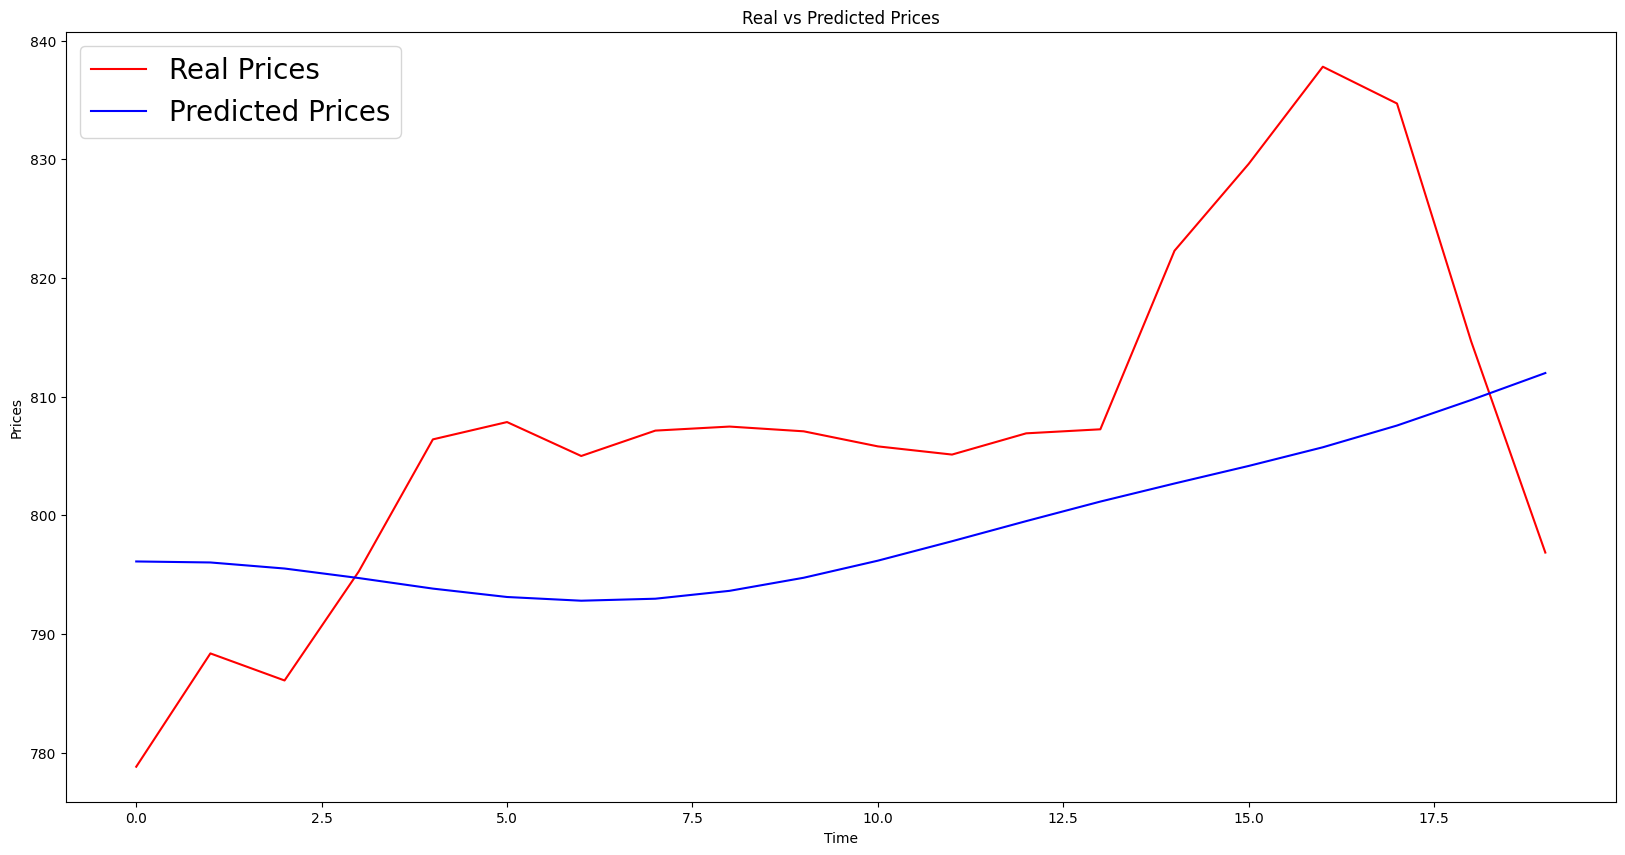

In [25]:
predicted_value= grid_search.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value.reshape(-1,1))
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)